In [1]:
import pandas as pd
import regex as re
import numpy as np

import torch
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, lr_scheduler

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
SEP_TOKEN = '▁<extra_id_0>'    # ' ; '

In [3]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    # Фильтрация
    text = re.sub ('``', '\"', text)
    text = re.sub ('\'\'', '\"', text)
    text = re.sub ('[“”]', '\"', text)

    # Создаем регулярное выражение для разделителей
    delimiters_pattern = '|'.join(map(re.escape, delimiters))
    
    # Разделяем текст на абзацы
    paragraphs = text.split ('\n')
    
    # Список для хранения предложений и их индексов
    sentences_with_segments = []
    
    current_start_index = 0
    # Обрабатываем каждый абзац
    for paragraph in paragraphs:
        # Разделяем абзац на предложения
        sentences = re.split (f'(?<=[{delimiters_pattern}]) (?=[A-ZА-ЯЁ])', paragraph.strip ())

        #print ('\nРассматривается параграф: ', paragraph)
        
        # Сопоставляем предложения с сегментами
        for sentence in sentences:
            #print ('> Предложение:', sentence)
            # Ищем индексы символов для текущего предложения
            start_index = current_start_index
            end_index = start_index + len (sentence)
            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index += len (sentence)

            #print ('Термины:', matched_segments)
    
    return sentences_with_segments

parallel_text = []
parallel_label = []
#for i, row in tqdm (df.iterrows (), total = df.shape [0], desc = "Processing texts: "):
for i, row in df.iterrows ():
    text = row ['text']
    segments = row ['label']
    splitted = split_text (text, segments)
    for sentence, terms in splitted:
        parallel_text.append (sentence)
        constructed_label = ''
        for term in terms:
            constructed_label += term.strip () + SEP_TOKEN
        if len (constructed_label) > 0:
            parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
        else:
            parallel_label.append ('')

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  


Попробовать: https://huggingface.co/IlyaGusev/rubert_ext_sum_gazeta

в дополнение - https://colab.research.google.com/drive/1Q8_v3H-kxdJhZIiyLYat7Kj02qDq7M1L#scrollTo=6orjdow-0nWp


https://huggingface.co/2KKLabs/Lacia_sum_small_v1/tree/main

https://huggingface.co/d0rj/rut5-base-summ/tree/main

https://huggingface.co/sarahai/ru-sum/tree/main


In [4]:
#USED_MODEL_NAME = 'cointegrated/rut5-small'
#USED_MODEL_NAME = './coint_rut5small_finetune_4459'
#USED_MODEL_NAME = 'ai-forever/ruT5-base'
#USED_MODEL_NAME = 'cointegrated/rut5-base-absum'
USED_MODEL_NAME = 'd0rj/rut5-base-summ'
SEQ_MAX_LENGTH = 150
BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4

In [5]:
#tokenizer = T5Tokenizer.from_pretrained (USED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)
tokenizer

T5TokenizerFast(name_or_path='d0rj/rut5-base-summ', vocab_size=32100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<ex

In [6]:
#tokenizer.add_special_tokens ({'additional_special_tokens': str (SEP_TOKEN)})
#tokenizer

In [7]:
enc = tokenizer (parallel_label [3], padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
enc


{'input_ids': tensor([[  939,  3669,   154,  4441,    19,     8, 32099,  7475,    13,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [8]:
tokenizer.batch_decode (enc ['input_ids'])

['Речевые формулы <extra_id_0> диалоге</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [9]:
train_data_txt, temp_data_txt, train_labels_txt, temp_labels_txt = train_test_split (parallel_text, parallel_label, test_size = 0.2, random_state = 14)
val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (temp_data_txt, temp_labels_txt, test_size = 0.5, random_state = 14)

In [10]:
train_data = tokenizer (train_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (train_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

val_data = tokenizer (val_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_data_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_labels_txt, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

In [11]:
class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

train_dataset = Seq2SeqDataset (train_data, train_labels)
val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader (val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = BATCH_SIZE)
#test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = T5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)
#model.train ()

cuda:0


In [13]:
print (parallel_text [3])
enc = tokenizer (parallel_text [3], padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt').to (model.device)
out = model.generate (input_ids = enc ['input_ids'], attention_mask = enc ['attention_mask'], max_length=SEQ_MAX_LENGTH, num_beams=3, do_sample=False, repetition_penalty=10.0)
print (tokenizer.decode (out [0]))

Речевые формулы в диалоге
<pad> Речевые формулы в диалоге с конкретикой</s>


In [14]:
def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    #txt = tokenizer.decode (seq [0])
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [15]:
metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

In [ ]:
for param in model.parameters ():
    param.requires_grad = True

In [ ]:
#optimizer = AdamW (model.parameters (), lr = 1e-5, weight_decay = 0.01)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr=5e-5)
#scheduler = lr_scheduler.StepLR (optimizer, step_size = 5, gamma = 0.5)

In [17]:
num_epochs = 15
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0
    
    for batch in tqdm (train_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

    #scheduler.step ()  # Обновление learning rate

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)
            #print (tokenizer.decode (out [0]))

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

    avg_val_loss = total_val_loss / len (val_loader)
    metrics ['val_loss'].append ((epoch, avg_val_loss))

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

100%|██████████| 837/837 [02:38<00:00,  5.27it/s]


Epoch 1 / 15, Loss: 0.2113, Validation loss: 0.1171, 0.1763779527559055 / 0.0653061224489796 / 0.09531914893617022


100%|██████████| 837/837 [02:35<00:00,  5.39it/s]


Epoch 2 / 15, Loss: 0.1148, Validation loss: 0.0946, 0.19130434782608696 / 0.07696793002915452 / 0.10977130977130976


100%|██████████| 837/837 [02:34<00:00,  5.40it/s]


Epoch 3 / 15, Loss: 0.0955, Validation loss: 0.0842, 0.2053072625698324 / 0.08571428571428572 / 0.120937885643768


100%|██████████| 837/837 [02:34<00:00,  5.40it/s]


Epoch 4 / 15, Loss: 0.0829, Validation loss: 0.0767, 0.2273342354533153 / 0.09795918367346938 / 0.13691931540342298


100%|██████████| 837/837 [02:34<00:00,  5.40it/s]


Epoch 5 / 15, Loss: 0.0730, Validation loss: 0.0718, 0.23822341857335128 / 0.1032069970845481 / 0.1440195280716029


100%|██████████| 837/837 [02:34<00:00,  5.40it/s]


Epoch 6 / 15, Loss: 0.0651, Validation loss: 0.0707, 0.24663072776280323 / 0.10670553935860058 / 0.14896214896214896


100%|██████████| 837/837 [02:36<00:00,  5.36it/s]


Epoch 7 / 15, Loss: 0.0592, Validation loss: 0.0682, 0.24360699865410498 / 0.1055393586005831 / 0.14727420667209112


100%|██████████| 837/837 [02:35<00:00,  5.39it/s]


Epoch 8 / 15, Loss: 0.0541, Validation loss: 0.0662, 0.25377229080932784 / 0.10787172011661808 / 0.15139116202945993


100%|██████████| 837/837 [02:35<00:00,  5.38it/s]


Epoch 9 / 15, Loss: 0.0491, Validation loss: 0.0662, 0.24512534818941503 / 0.10262390670553936 / 0.1446773530620633


100%|██████████| 837/837 [02:35<00:00,  5.40it/s]


Epoch 10 / 15, Loss: 0.0455, Validation loss: 0.0651, 0.2520775623268698 / 0.10612244897959183 / 0.14936397209684038


100%|██████████| 837/837 [02:35<00:00,  5.40it/s]


Epoch 11 / 15, Loss: 0.0416, Validation loss: 0.0645, 0.2596685082872928 / 0.10962099125364431 / 0.15416154161541615


100%|██████████| 837/837 [02:35<00:00,  5.39it/s]


Epoch 12 / 15, Loss: 0.0379, Validation loss: 0.0644, 0.24651810584958217 / 0.1032069970845481 / 0.14549938347718866


100%|██████████| 837/837 [02:36<00:00,  5.36it/s]


Epoch 13 / 15, Loss: 0.0353, Validation loss: 0.0639, 0.24895104895104894 / 0.10379008746355685 / 0.14650205761316873


100%|██████████| 837/837 [02:36<00:00,  5.35it/s]


Epoch 14 / 15, Loss: 0.0327, Validation loss: 0.0651, 0.2443820224719101 / 0.10145772594752187 / 0.1433868974042027


100%|██████████| 837/837 [02:36<00:00,  5.36it/s]


Epoch 15 / 15, Loss: 0.0304, Validation loss: 0.0659, 0.26675977653631283 / 0.11137026239067055 / 0.15713698066639242


In [18]:
print (metrics)

{'train_loss': [(0, 0.2112988575718843), (1, 0.11483847035435579), (2, 0.09549942416146735), (3, 0.08294247367320273), (4, 0.07303378022506192), (5, 0.06506307726100603), (6, 0.05922123171798573), (7, 0.054075727679876874), (8, 0.04911821484543481), (9, 0.045505422323256765), (10, 0.041575835054693575), (11, 0.03791223858035834), (12, 0.03526078425308861), (13, 0.03270466850732265), (14, 0.030381192409115194)], 'val_loss': [(0, 0.11708128839021638), (1, 0.09464453027716704), (2, 0.08417227433196135), (3, 0.0767431541567757), (4, 0.0717966607461373), (5, 0.07067910837275641), (6, 0.06820218101853416), (7, 0.06621841476077125), (8, 0.06621517535476458), (9, 0.06508736395764919), (10, 0.06448384918982074), (11, 0.06444436771174272), (12, 0.06394062884861515), (13, 0.06509221976711636), (14, 0.06591395085588807)], 'precision': [(0, 0.1763779527559055), (1, 0.19130434782608696), (2, 0.2053072625698324), (3, 0.2273342354533153), (4, 0.23822341857335128), (5, 0.24663072776280323), (6, 0.24360

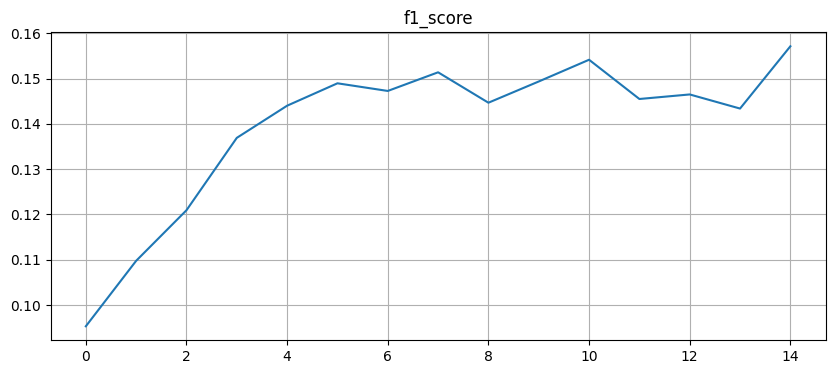

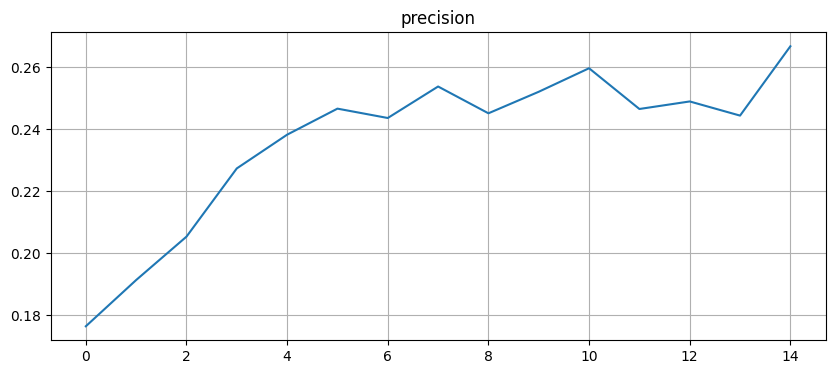

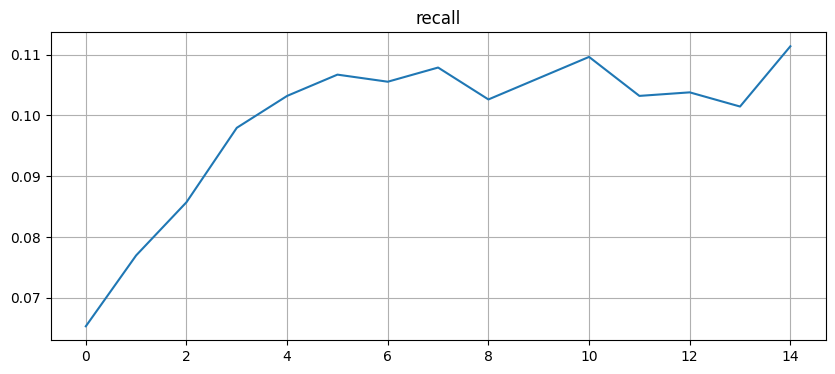

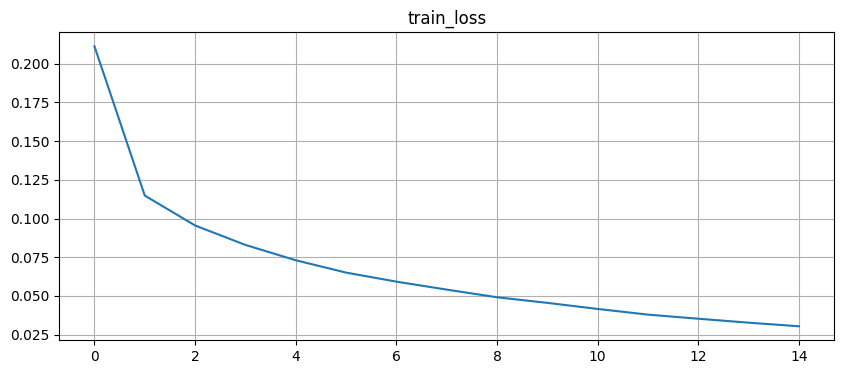

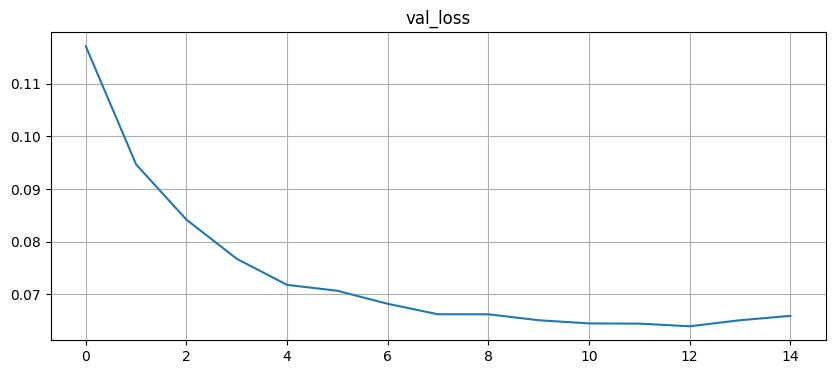

In [19]:
'''plt.figure (figsize = (10, 4))
for i, (name, history) in enumerate (sorted (metrics.items ())):
    plt.subplot (1, len (metrics), i + 1)
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
plt.show ()'''

for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()


In [20]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model (input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        outputs = outputs.logits.argmax(-1)

        #print (outputs)
        print (tokenizer.batch_decode (labels))
        print (tokenizer.batch_decode (outputs))

        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        print (sanity_check (outputs, labels, to_print = True))

        break

['семантики <extra_id_0> термина <extra_id_0> терминоведения <extra_id_0> переводоведения <extra_id_0> лексикографии</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', 'глобальную оптимизацию <extra_id_0> оптимизацию <extra_id_0> генетического алгоритма <extra_id_0> алгоритма <extra_id_0> эвристик <extra_id_0> размерность задачи</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [21]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [22]:

model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation: ', sanity_check (val_preds, val_labels))


val_preds, val_labels = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)
        #out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH, num_beams=3)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test: ', sanity_check (val_preds, val_labels))

100%|██████████| 105/105 [01:51<00:00,  1.06s/it]


Validation:  (0.26675977653631283, 0.11137026239067055, 0.15713698066639242)


100%|██████████| 105/105 [01:47<00:00,  1.02s/it]


Test:  (0.296448087431694, 0.1340333539221742, 0.18460229689493834)


In [23]:

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Validation wmax: ', sanity_check (val_preds, val_labels))

val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        #out = model.generate (input_ids = input_ids, attention_mask = attention_mask)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)

    print ('Test wmax: ', sanity_check (val_preds, val_labels))

100%|██████████| 105/105 [01:52<00:00,  1.07s/it]


Validation wmax:  (0.26675977653631283, 0.11137026239067055, 0.15713698066639242)


100%|██████████| 105/105 [01:46<00:00,  1.02s/it]


Test wmax:  (0.296448087431694, 0.1340333539221742, 0.18460229689493834)


In [24]:
val_preds [0]

tensor([    0,    11,    13,   740,  4284,     8, 32099,  4228,     7,     2,
            0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')

In [25]:
#model.save_pretrained('./coint_rut5-base-absum_finetune_5982-7597')
#tokenizer.save_pretrained('./coint_rut5-base-absum_finetune_5982-7597')

In [26]:
'''checkpoint = { 
    'epoch': 45,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save (checkpoint, './coint_rut5-base-absum_finetune_5982-7597/checkpoint.pth')'''

"checkpoint = { \n    'epoch': 45,\n    'model': model.state_dict(),\n    'optimizer': optimizer.state_dict()}\ntorch.save (checkpoint, './coint_rut5-base-absum_finetune_5982-7597/checkpoint.pth')"